In [24]:
import torchdrug

In [25]:
torchdrug.__version__

'0.2.0'

In [1]:
from torchdrug import datasets

SUBCELLULAR_PATH = "/home/ec2-user/esm/"


In [26]:
from torchdrug import transforms
from torchdrug import datasets

truncate_transform = transforms.TruncateProtein(max_length=1024, random=False)
protein_view_transform = transforms.ProteinView(view="residue")
transform = transforms.Compose([truncate_transform, protein_view_transform])
dataset = datasets.SubcellularLocalization(SUBCELLULAR_PATH, atom_feature=None, bond_feature=None, residue_feature="default", transform=transform)

22:34:09   Extracting /home/ec2-user/esm/subcellular_localization.tar.gz to /home/ec2-user/esm


Constructing proteins from sequences:  10%|█         | 1440/14004 [00:02<00:23, 545.19it/s]/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchdrug/data/protein.py:261: UserWarning: Unknown residue symbol `U`. Treat as glycine
  warnings.warn("Unknown residue symbol `%s`. Treat as glycine" % residue)
Constructing proteins from sequences:  48%|████▊     | 6661/14004 [00:12<00:13, 531.47it/s]/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchdrug/data/protein.py:261: UserWarning: Unknown residue symbol `X`. Treat as glycine
  warnings.warn("Unknown residue symbol `%s`. Treat as glycine" % residue)
Constructing proteins from sequences:  57%|█████▋    | 7969/14004 [00:14<00:07, 830.64it/s]/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchdrug/data/protein.py:261: UserWarning: Unknown residue symbol `B`. Treat as glycine
  warnings.warn("Unknown residue symbol `%s`. Treat as glycine" % residue)
Constructing proteins from sequences:  97%|█████████▋| 13533/14004 [00:23<00:00

In [47]:
dataset[0]

{'graph': Protein(num_atom=0, num_bond=0, num_residue=484), 'localization': 0}

In [29]:
train_set, valid_set, test_set = dataset.split()

In [30]:
print("The label of first sample: ", dataset[0][dataset.target_fields[0]])
print("train samples: %d, valid samples: %d, test samples: %d" % (len(train_set), len(valid_set), len(test_set)))

The label of first sample:  0
train samples: 8420, valid samples: 2811, test samples: 2773


In [42]:
prot_seq = dataset[0]['graph'].to_sequence().replace('.', '')

In [52]:
import pandas as pd
from tqdm import tqdm

seq = []
for item in tqdm(train_set):
    aa = item['graph'].to_sequence().replace('.', '')
    loc = item['localization']
    seq.append({'seq': aa, 'loc': loc, 'split': 'train'})

for item in tqdm(valid_set):
    aa = item['graph'].to_sequence().replace('.', '')
    loc = item['localization']
    seq.append({'seq': aa, 'loc': loc, 'split': 'val'})

for item in tqdm(test_set):
    aa = item['graph'].to_sequence().replace('.', '')
    loc = item['localization']
    seq.append({'seq': aa, 'loc': loc, 'split': 'test'})

seq = pd.DataFrame(seq)

100%|██████████| 2773/2773 [00:01<00:00, 1443.45it/s]


In [53]:
seq.to_csv('protein_loc.csv')

## Load embeddings and train localization model

In [75]:
import pandas as pd
import zarr

GENE2PROTEIN_PATH = '/home/ec2-user/rosa/notebooks/protein_loc.csv'
PROTEIN_EMBED_PATH = "/home/ec2-user/esm/ESM_proteins_loc_embeddings_var_0.zarr"

seq = pd.read_csv(GENE2PROTEIN_PATH)
embed = np.asarray(zarr.open(PROTEIN_EMBED_PATH))

In [76]:
print(len(seq))

14004


In [77]:
print(embed.shape)

(14004, 2, 1280)


In [107]:
from sklearn.linear_model import LogisticRegression


index = (seq['split'] == 'train').values
id = 1
X_train = embed[index, id]
y_train = seq[index]['loc']

index = (seq['split'] == 'val').values
X_val = embed[index, id]
y_val = seq[index]['loc']

index = (seq['split'] == 'test').values
X_test = embed[index, id]
y_test = seq[index]['loc']

In [108]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [109]:
y_predict = clf.predict(X_test)

In [110]:
from sklearn.metrics import confusion_matrix, accuracy_score

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict)

Accuracy 0.8031013342949874


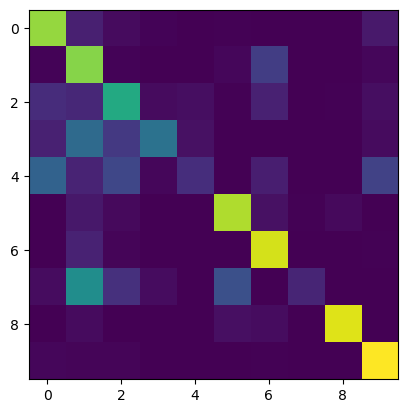

In [111]:
import matplotlib.pyplot as plt

plt.imshow(cm / cm.sum(axis=1)[:, None])

## Images